## MLP

Based on findings in svm notebook.

In [302]:
%load_ext autoreload
%autoreload 2

import re
import itertools
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from nltk.tokenize import TweetTokenizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [303]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [304]:
print(len(train_df))

targets_df = train_df.groupby('text').nunique().sort_values(by='target', ascending=False)
mismatched_texts = list(targets_df[targets_df['target'] > 1].index)

# DROPPING duplicates
# train_df = train_df[train_df['text'].isin(mismatched_texts) == False]
# train_df.reset_index(drop=False)
# print(len(train_df))

7613


In [305]:
# FIXING duplicates

duplicates_df = train_df[train_df['text'].isin(mismatched_texts) == True]
duplicates_df

,id,keyword,location,text,target
610,881,bioterrorism,NaN,To fight bioterrorism sir.,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0
1197,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1214,1752,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1221,1760,buildings%20burning,dallas,like for the music video I want some real acti...,1
1331,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0
1349,1950,burning%20buildings,dallas,like for the music video I want some real acti...,0
1365,1968,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,1


In [306]:
train_df.loc[train_df['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
train_df.loc[train_df['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0
train_df.loc[train_df['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0

train_df = train_df[train_df['text'].isin(mismatched_texts) == False]
train_df.reset_index(drop=False)
print(len(train_df))
duplicates_df = train_df[train_df['text'].isin(mismatched_texts) == True]
duplicates_df

7558


,id,keyword,location,text,target,target_relabeled


In [307]:
train_df['text'].isnull().values.any()

False

## Preprocessing

In [308]:

EXTENDED_STRIP_REGEX = r'[!"#$%&()\*\+,-\./:;„”<=>?@\[\\\]^_`{|}~\']'
REMOVE_NUMERICAL = r'[0-9]'

def _preprocessing(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(r'http?:\/\/t.co\/[A-Za-z0-9]+', '', txt)
    txt = re.sub(r'@[A-Za-z0-9]+', '', txt)
    txt = re.sub(EXTENDED_STRIP_REGEX, '', txt)
    txt = re.sub(REMOVE_NUMERICAL, '', txt)
    return txt

train_df['text_preproc'] = train_df['text'].apply(_preprocessing)
test_df['text_preproc'] = test_df['text'].apply(_preprocessing)

nlp = spacy.load('en_core_web_sm')

# disable not used parts of pipeline
def _lemma(txt: str) -> str:
    return ' '.join([d.lemma_ for d in nlp(txt)])

# train_df['text_preproc'] = train_df['text_preproc'].apply(_lemma)
train_df[:3]

,id,keyword,location,text,target,target_relabeled,text_preproc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,all residents asked to shelter in place are be...


## Data split

In [309]:
X_all = train_df['text_preproc']
y_all = train_df['target']

X_all[:3]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
Name: text_preproc, dtype: object

In [310]:
X = X_all.to_numpy()
y = y_all.to_numpy()

X[:3]

array(['our deeds are the reason of this earthquake may allah forgive us all',
       'forest fire near la ronge sask canada',
       'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected'],
      dtype=object)

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:3]

array([' i see that crazy how this line blew up',
       'panic attacks are the worst ',
       'retweeted sarah silverman \n\nsoundtrack of my walk starts w tracey ullman they dont know  perfect'],
      dtype=object)

## Experiments center

In [312]:
sequence_length = 400
embedding_dim = 16
hidden_layer_units = 64
dropout_rate = 0.2
batch_size = 32
iter_count = 1
training_epochs = 3

## Vectorization

In [313]:
def _create_vect_layer(training_text):
    vect_layer = TextVectorization(
        output_mode='int',
        output_sequence_length=sequence_length
    )
    vect_layer.adapt(training_text)
    return vect_layer

def vectorize_text(vect_layer, text):
    text = tf.expand_dims(text, -1)
    ret = vect_layer(text).numpy()
    return ret

vectorize_layer = _create_vect_layer(training_text=X_train)

voc = vectorize_layer.get_vocabulary()
voc[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'i', 'and', 'is']

In [314]:
test_text = '@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

print(_preprocessing(test_text))
vectorize_text(vectorize_layer, '@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C')

 wholesale markets ablaze 


array([[   1, 3722, 2130,  694,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

## Model

In [315]:
num_tokens = len(voc) + 1
print(f'Number of tokens={num_tokens}')

def create_model(vec_layer: str, num_tokens: str, embedding_dim: str, sequence_length: str,
                 hidden_layer_units: str, dropout_rate: str) -> str:
    m = tf.keras.models.Sequential()
    m.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    m.add(vec_layer)
    m.add(layers.Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=sequence_length))
    m.add(layers.Flatten())
    m.add(layers.Dense(units=hidden_layer_units, activation='relu'))
    m.add(layers.Dropout(rate=dropout_rate))
    m.add(layers.Dense(units=1, activation='sigmoid'))

    return m

model = create_model(vectorize_layer, num_tokens, embedding_dim, sequence_length, hidden_layer_units, dropout_rate)

# first `None` is the batch dimension
model.summary()

Number of tokens=13727
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 16)           219632    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 629,361
Trainable params: 629,361
Non-trainable params: 0
_________________________

In [316]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [317]:
history = model.fit(x=X_train, y=y_train, epochs=training_epochs,
                    batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/3
189/189 [==============================] - 2s 6ms/step - loss: 0.6792 - accuracy: 0.5793 - val_loss: 0.5464 - val_accuracy: 0.7348

48/48 [==============================] - 0s 2ms/step - loss: 0.4664 - accuracy: 0.8108
Loss:  0.46641331911087036
Accuracy:  0.8108465671539307


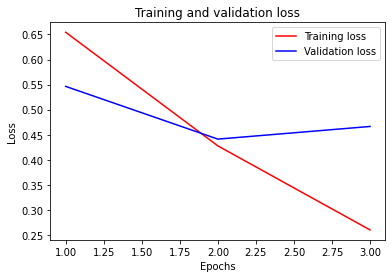

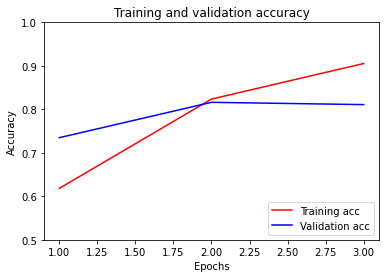

In [318]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

axes = plt.gca()
axes.set_ylim([0.5, 1])

max_val_acc = f'{np.max(history_dict["val_accuracy"]):.3f}'
mean_val_acc = f'{np.mean(history_dict["val_accuracy"]):.3f}'

# plt.savefig(f'mlp_max{max_val_acc}_mean{mean_val_acc}_embdim{embedding_dim}_units{hidden_layer_units}'
#             f'_drop{dropout_rate}_batch{batch_size}_{iter_count}.png')

plt.show()

c:\users\mikol\miniconda3\envs\kaggle02\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[765 102]
 [184 461]]
Normalized confusion matrix


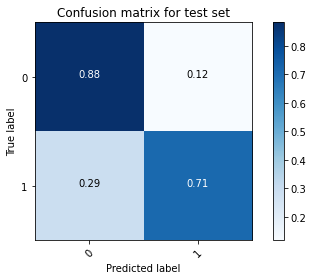

In [319]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix for test set',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.print(classification_report(y_test, y_pred_test))
    """
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_pred_test = model.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm, [0, 1])

In [320]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       867
           1       0.82      0.71      0.76       645

    accuracy                           0.81      1512
   macro avg       0.81      0.80      0.80      1512
weighted avg       0.81      0.81      0.81      1512



In [321]:
plt.ioff()

## Cross validation

TRAIN: 5668 TEST: 1890
Epoch 1/3
178/178 [==============================] - 2s 7ms/step - loss: 0.6859 - accuracy: 0.5514 - val_loss: 0.6196 - val_accuracy: 0.6741

c:\users\mikol\miniconda3\envs\kaggle02\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
c:\users\mikol\miniconda3\envs\kaggle02\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does bi

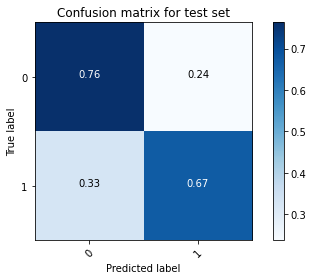

In [322]:
X_cv = X_all.copy()
y_cv = y_all.copy()

CONF_MATRIXES = []

skf = StratifiedKFold(n_splits=4)
for train_idx, test_idx in skf.split(X_cv, y_cv):
    print('TRAIN:', len(train_idx), 'TEST:', len(test_idx))
    X_train_cv, X_test_cv = X_cv.iloc[train_idx].to_numpy(), X_cv.iloc[test_idx].to_numpy()
    y_train_cv, y_test_cv = y_cv.iloc[train_idx].to_numpy(), y_cv.iloc[test_idx].to_numpy()

    vectorize_layer_cv = _create_vect_layer(training_text=X_train_cv)
    voc_cv = vectorize_layer_cv.get_vocabulary()

    model_cv = create_model(vectorize_layer_cv, len(voc_cv) + 1, embedding_dim,
                         sequence_length, hidden_layer_units, dropout_rate)
    model_cv.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    history_cv = model_cv.fit(x=X_train_cv, y=y_train_cv, epochs=training_epochs,
                           batch_size=batch_size, validation_data=(X_test_cv, y_test_cv))

    print('\n')
    loss_cv, accuracy_cv = model_cv.evaluate(X_test_cv, y_test_cv)
    print(f'TRAIN LOSS: {loss_cv} / TEST ACCURACY: {accuracy_cv}')
    y_pred_test_cv = model_cv.predict_classes(X_test_cv)
    cm = confusion_matrix(y_test_cv, y_pred_test_cv)
    CONF_MATRIXES.append(cm)
    print('\n')

    tf.keras.backend.clear_session()

# overall results
cm = np.array(CONF_MATRIXES).sum(axis=0)
plot_confusion_matrix(cm, [0, 1])

## Final model training

Epoch 1/3
237/237 [==============================] - 2s 5ms/step - loss: 0.6815 - accuracy: 0.5718

c:\users\mikol\miniconda3\envs\kaggle02\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


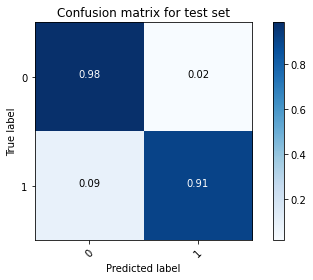

In [323]:
X_final = X_all.copy().to_numpy()
y_final = y_all.copy().to_numpy()

vectorize_layer_final = _create_vect_layer(training_text=X_final)
voc_final = vectorize_layer_final.get_vocabulary()
num_tokens_final = len(voc_final) + 1

model_final = create_model(vectorize_layer_final, num_tokens_final, embedding_dim,
                         sequence_length, hidden_layer_units, dropout_rate)

model_final.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model_final.fit(x=X_final, y=y_final, epochs=training_epochs, batch_size=batch_size)

loss_final, accuracy_final = model_final.evaluate(X_final, y_final)
print(f'TRAIN LOSS: {loss_final} / TEST ACCURACY: {accuracy_final}')
y_pred_final = model_final.predict_classes(X_final)
cm = confusion_matrix(y_final, y_pred_final)
plot_confusion_matrix(cm, [0, 1])

In [324]:
test_df[:3]

,id,keyword,location,text,text_preproc
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...


In [325]:
X_out = test_df['text_preproc'].to_numpy()
X_out

array(['just happened a terrible car crash',
       'heard about earthquake is different cities stay safe everyone',
       'there is a forest fire at spot pond geese are fleeing across the street i cannot save them all',
       ..., 'green line derailment in chicago ',
       'meg issues hazardous weather outlook hwo ',
       'cityofcalgary has activated its municipal emergency plan yycstorm'],
      dtype=object)

In [326]:
y_out_pred = model_final.predict_classes(X_out)
y_out_pred

c:\users\mikol\miniconda3\envs\kaggle02\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [327]:
file = pd.DataFrame({
   'id': test_df['id'],
   'target': [v[0] for v in y_out_pred]
})

file.to_csv('disaster-tweets-mlp-fix-dupl.csv', index=False)